# Pendulum Simulation and Phase Plot

In this notebook we produce a simulation of the motion of a pendulum using the `odeint` program from the scipy library to exactly solve the equations of motion for both simple and damped cases. The phase diagrams and their relevant key features are plotted and discussed.

### Simple Pendulum

Importing the necessary libraries first:

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import glob
import os

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


For the majority of this code we will use the Runga-Kutta 4 method of solving ODEs, below we implement the RK4 numerical solving system for solving the ODEs. Although not necessary for the simple pendulum it will be mirrored in solving the ODEs of the double pendulum which does not have analytic solutions to its Lagrangian.

In [2]:
# Function for taking a single RK4 step
# The grad function must be of form grad(time (float), state (numpy array of floats)) -> (numpy array of floats)
def rk4_step(grad, time, state, step_size):
    # Calculate various midpoint k states
    k1 = grad(time, state)*step_size
    k2 = grad(time+step_size/2, state+k1/2)*step_size
    k3 = grad(time+step_size/2, state+k2/2)*step_size
    k4 = grad(time+step_size, state+k3)*step_size
    # Return new time and state
    return time+step_size, state+(k1/2 + k2 + k3 + k4/2)/3

# Function for taking n steps using RK4
def rk4_n_steps(grad, time, state, step_size, n_steps):
    # Prepare numpy arrays for storing data
    times = np.array([time,])
    state_arr = np.empty(shape=(0,state.size))
    # We will use vstack to add new time slices the state array
    state_arr = np.vstack((state_arr, state))
    
    # Take n steps
    for _ in range(n_steps):
        new_time, new_state = rk4_step(grad, times[-1], state_arr[-1], step_size)
        times = np.append(times, new_time)
        state_arr = np.vstack((state_arr, new_state))
    
    return times, state_arr

# Function for taking steps till some final time using RK4. Useful for comparing step sizes
def rk4_step_till(grad, time, state, step_size, final_time):
    # Prepare numpy arrays for storing data
    times = np.array([time,])
    state_arr = np.empty(shape=(0,state.size))
    # We will use vstack to add new time slices the state array
    state_arr = np.vstack((state_arr, state))
    
    # Take as many steps as needed
    while times[-1] < final_time:
        new_time, new_state = rk4_step(grad, times[-1], state_arr[-1], step_size)
        times = np.append(times, new_time)
        state_arr = np.vstack((state_arr, new_state))
    
    return times, state_arr

Our equation of motion is as follows,
$$ml \ddot θ=−mgsin(θ)$$
which we can rearange into the form,
$$\ddot θ=−\frac{g}{l}sin(θ)$$
Now we define a series of functions to solve the equations of motion and produce a phase plot of the relevant 'interesting' orbits

In [3]:
def simple_pend_grad(time, state, m=1.0, l=1.0, g=9.8):
    """
    Produce a state array for the simple pendulum.

    Parameters
    ----------
    time : float
        The time at which the pendulum's conditions are being evaluated.
    state: list
        The current state of the pendulum. Single list in [theta, theta_dot] form.  
    m : float, optional
        The mass of the pendulum in kg. The default is 1.0
    l : float, optional
        The length of the pendulum in m. The default is 1.0
    g : float, optional
        The gravitational acceleration acting on the pendulum. The default is 9.8
        
    Returns
    -------
    np.ndarray
        Time derivative of first generalised coordinate - the angular velocity,
        time derivative of second generalised coordinate - the angular acceleration.
    
    """
    
    theta, theta_dot = state[0], state[1]
    
    x1_dot = theta_dot
    x2_dot = -(g/l)*np.sin(theta)
    
    return np.array([x1_dot, x2_dot])

def plot_orbit(x0_vect):
    """
    Plot the phase space of the pendulum for the single orbit being considered.
    
    Parameters
    ----------
    x0_vect : np.ndarray
        The initial conditions for the pendulum, in [theta, theta_dot] form.
        
    Returns
    -------
    None.
    """
    
    t_0 = 0
    
    times, states = rk4_n_steps(simple_pend_grad, t_0, x0_vect, 0.001, 5000)
    
    plt.plot(states[:,0], states[:,1])



def plot_interesting_orbits():
    """
    Plots a collection of orbits for the simple pendulum that help visualise
    the entire phase space.
    
    Returns
    -------
    None.
    """
    
    plt.clf()

    plot_orbit(np.array([np.pi * 0.25, 0.0]))
    plot_orbit(np.array([np.pi * 0.5, 0.0]))
    plot_orbit(np.array([np.pi * 0.9, 0.0]))
    plot_orbit(np.array([np.pi * 0.999, 0.0]))
    plot_orbit(np.array([np.pi * -5.0, 2.5]))
    plot_orbit(np.array([np.pi * 5.0, -2.5]))
    plot_orbit(np.array([np.pi * -5.0, 5.0]))
    plot_orbit(np.array([np.pi * 5.0, -5.0]))
    
    plt.plot(0, 0, marker='x', color='black')
    plt.plot([-np.pi, np.pi], [0, 0], marker='x', color='grey', linewidth=0)
    
    plt.title('Orbits for an undamped simpled pendulum')
    plt.xlim([-3.5,3.5])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\dot{\theta}$')
    plt.show()

Below we define a series of functions to simulate a video of the pendulum so that its motion can be intuitively understood (not functioning yet unfortunately)

In [4]:
def pendulum_video( q0, ts, output_file):
    ts = np.linspace(0.0, 5.0, 101)
    qs = odeint(simple_pend_grad, q0, ts, args = (1.0, 1.0, 9.8))
    pendulum_video_sequence(qs, output_file)

def encode_video(input_pattern, output_filename):
    # taken (almost) directly from the matplotlib website:
    # http://matplotlib.sourceforge.net/faq/howto_faq.html#make-a-movie
    os.system("mencoder 'mf://%s' -mf type=png:fps=10 -ovc lavc -lavcopts vcodec")

def pendulum_video_sequence(qs, output_filename):
    for n, q in enumerate(qs):
        print(n, q)
        plt.clf()
        plot_orbit( q )
        plt.savefig( '_tmp%03d.png' % n )
    encode_video('_tmp*.png', output_filename)
    for fname in glob.glob('_tmp*.png'):
        os.remove(fname)

def interesting_videos():
    ts = np.linspace(0.0, 50.0, 501)
    pendulum_video( np.array([np.pi/2.0, 0.0]), ts, 'undamped_simple_pendulum01.mp4' )
    pendulum_video( np.array([3*np.pi/4.0, 0.0]), ts, 'undamped_simple_pendulum02.mp4' )

Calling the initial set of functions to produce the phase space plot below we get:

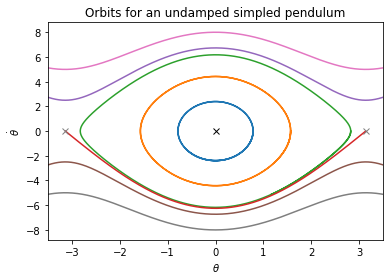

In [5]:
plot_interesting_orbits()

Calling the simulation producing functions below produces the following video:

In [6]:
#interesting_videos()

### Damped Pendulum

With a small adjustment we are able to also account for the damping of the pendulum due to real-world effects

In [7]:
def damped_pend_grad(time, state, m=1.0, l=1.0, g=9.8, b=1.0):
    """
    Produce a state array for the damped pendulum.

    Parameters
    ----------
    time : float
        The time at which the pendulum's conditions are being evaluated.
    state: list
        The current state of the pendulum. Single list in [theta, theta_dot] form.
    m : float, optional
        The mass of the pendulum in kg. The default is 1.0
    l : float, optional
        The length of the pendulum in m. The default is 1.0
    g : float, optional
        The gravitational acceleration acting on the pendulum in m/s^2. The default is 9.8
    b : float, optional
        The damping factor of the pendulum in kg/s. The default is 1.0
        
    Returns
    -------
    np.ndarray
        Time derivative of first generalised coordinate - the angular velocity,
        time derivative of second generalised coordinate - the angular acceleration.
    
    """

    theta, theta_dot = state[0], state[1]
    
    x1_dot = theta_dot
    x2_dot = -(g/l)*np.sin(theta) - (b/m) * theta_dot
    
    return np.array([x1_dot, x2_dot])

def plot_damped_orbit(x0_vect):
    """
    Plot the phase space of the damped pendulum for the single orbit being considered.
    
    Parameters
    ----------
    x0_vect : np.ndarray
        The initial conditions for the pendulum, in [theta, theta_dot] form.
        
    Returns
    -------
    None.
    """
    t_0 = 0
    
    times, states = rk4_n_steps(damped_pend_grad, t_0, x0_vect, 0.001, 5000)
    plt.plot(states[:,0], states[:,1])
    
def plot_interesting_damped_orbits():
    """
    Plots a collection of orbits for the damped pendulum that help visualise
    the entire phase space for the select damping factor.
    
    Returns
    -------
    None.
    """
    plt.clf()

    plot_damped_orbit(np.array([np.pi * 0.25, 0.0]))
#    plot_damped_orbit(np.array([np.pi * 0.5, 0.0]))
    plot_damped_orbit(np.array([np.pi * 0.5, 0.0]))
    plot_damped_orbit(np.array([np.pi * 0.999, 0.0]))
#    plot_damped_orbit(np.array([np.pi * -5.0, 2.5]))
#    plot_damped_orbit(np.array([np.pi * 5.0, -2.5]))
    plot_damped_orbit(np.array([np.pi * 0.5, 5.0]))
    plot_damped_orbit(np.array([np.pi * 0.5, -5.0]))

    plt.title('Phase Space for a Damped Pendulum')
    plt.xlim([-3.5, 3.5])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\dot{\theta}$')
    plt.show()

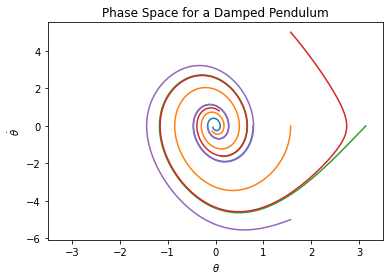

In [8]:
plot_interesting_damped_orbits()

### Forced Damped Pendulum

Now we consider a forcing term that represents a periodic force

In [9]:
# Define the function for the forced damped pendulum
def forced_damped_pend_grad(time, state, m=1.0, l=1.0, g=9.8, b=1.0, F=5.0, omega=5.0):
    """
    Produce a state array for the simple pendulum.

    Parameters
    ----------
    time : float
        The time at which the pendulum's conditions are being evaluated.
    state: list
        The current state of the pendulum. Single list in [theta, theta_dot, phase] form.
    m : float, optional
        The mass of the pendulum in kg. The default is 1.0
    l : float, optional
        The length of the pendulum in m. The default is 1.0
    g : float, optional
        The gravitational acceleration acting on the pendulum in m/s^2. The default is 9.8
    b : float, optional
        The damping factor of the pendulum in kg/s. The default is 1.0
    F : float, optional
        The magnitude of the driving term in N. The default is 5.0
    omega : float, optional
        The frequency of the driving term in rad/s. The default is 5.0
        
    Returns
    -------
    np.ndarray
        Time derivative of first generalised coordinate - the angular velocity,
        time derivative of second generalised coordinate - the angular acceleration,
        time derivative of third generalised coordinate - the driving frequency.
        
    
    """
    theta, theta_dot, phase = state[0], state[1], state[2]
    
    # Angular velocity
    x1_dot = theta_dot
    
    # Angular acceleration: gravity, damping, and external driving force
    x2_dot = -(g/l) * np.sin(theta) - (b/m) * theta_dot + (F/m) * np.cos(phase)
    
    # Phase evolution for the driving force
    x3_dot = omega
    
    return np.array([x1_dot, x2_dot, x3_dot])

In [10]:
t_0 = 0.1

def simulate_trajectory(initial_state):
    """
    Calls the RK4 method for a specified initial state to solve the forced damped ODEs
    numerically.
    
    Parameters
    ----------
    initial_state: list
        A list containing the initial conditions in [theta, theta_dot, phase] form.
    
    Returns
    -------
    times : np.ndarray
        An array of the times that each state was evaluated at, acts as an index.
    states : np.ndarray
        An array of the states for each time step.
    """
    times, states = rk4_n_steps(forced_damped_pend_grad, t_0, initial_state, 0.0001, 50000)
    return times, states

initial_conditions = [
    [0.1, 0.0, 0.0],   # Small angle
    [1.5, 0.5, 0.0],   # Larger angle, slow velocity
    [3.0, -1.0, 0.0],  # Large angle, reverse velocity
    [0.5, 2.0, 0.0],   # Moderate angle, fast velocity
    #[2.5, 3.0, 0.0],   # High energy trajectory
    [-1.5, -0.5, 0.0]  # Negative angle and velocity
]

trajectories = [simulate_trajectory(np.array(init)) for init in initial_conditions]

<IPython.core.display.Javascript object>


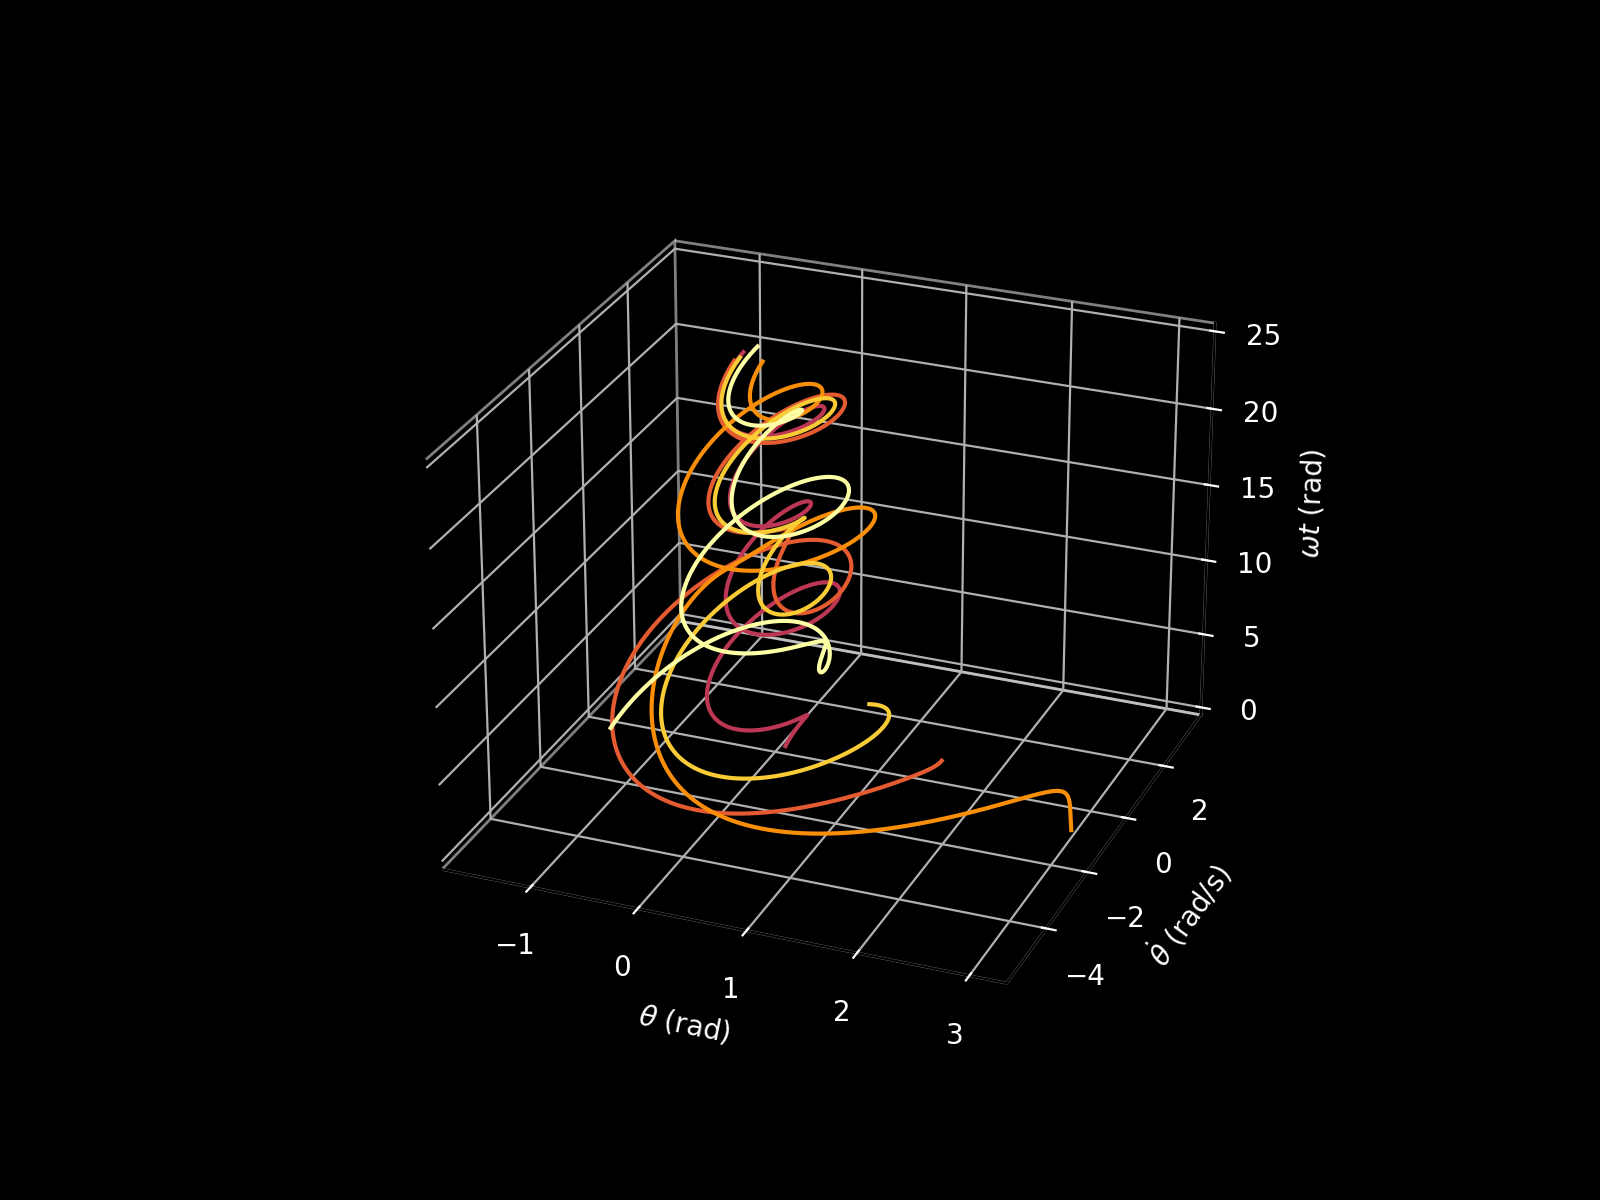

In [11]:
# Ensure interactive plotting in Jupyter Notebook
%matplotlib notebook 

# Create a new 3D figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


# Altering the visual design only ----

# Set the background color
fig.patch.set_facecolor('black')  # Outer background
ax.set_facecolor('black')         # Inner plot background

# Change grid and axis colors for better contrast
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')

# Make the panes (the 3D surfaces) transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Change tick and label colors
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')

# Colors for different trajectories
colors = plt.cm.inferno(np.linspace(0.5, 1, len(trajectories)))

# --------------------------------------


# Ensure trajectories are valid before plotting
for (times, states), color in zip(trajectories, colors):
    theta_vals = states[:, 0]
    theta_dot_vals = states[:, 1]
    omega_t_vals = states[:, 2]
    
    # Plot each trajectory in 3D space
    ax.plot(theta_vals, theta_dot_vals, omega_t_vals, color=color, lw=1.5)

# Labels for the 3D plot
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r'$\dot{\theta}$ (rad/s)')
ax.set_zlabel(r'$\omega t$ (rad)')

# Set plot title
ax.set_title("Interactive 3D Phase Space of the Forced Damped Pendulum")

# Display the plot
plt.show()